In [ ]:
!pip install rdkit

In [2]:
import os
from rdkit.Chem import AllChem
from rdkit import Chem
import torch
# torch.manual_seed(0)
import numpy as np
from torch_geometric.data import Data

from torch_geometric.data import DataLoader

from model import GNN_graphpred

from tqdm import tqdm

# from torchsummary import summary
from loader import CustomDataset

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import Birch

ModuleNotFoundError: No module named 'rdkit'

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# torch.autograd.set_detect_anomaly(True)

In [3]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [4]:
os.remove('data/processed/data_.pt')
dataset = CustomDataset(root="data")
loader = DataLoader(dataset, batch_size=1, shuffle=False)

Processing...
6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

6 8

Read 50 graphs
Done!


In [5]:
model = GNN_graphpred(num_layer=5, emb_dim=300, num_tasks=2, JK="last", drop_ratio=0.5, graph_pooling="mean")
model.from_pretrained("../chem/model_gin/supervised.pth")
model.to(device)

GNN_graphpred(
  (gnn): GNN(
    (x_embedding1): Embedding(120, 300)
    (x_embedding2): Embedding(3, 300)
    (gnns): ModuleList(
      (0): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=300, out_features=600, bias=True)
          (1): ReLU()
          (2): Linear(in_features=600, out_features=300, bias=True)
        )
        (edge_embedding1): Embedding(6, 300)
        (edge_embedding2): Embedding(3, 300)
      )
      (1): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=300, out_features=600, bias=True)
          (1): ReLU()
          (2): Linear(in_features=600, out_features=300, bias=True)
        )
        (edge_embedding1): Embedding(6, 300)
        (edge_embedding2): Embedding(3, 300)
      )
      (2): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=300, out_features=600, bias=True)
          (1): ReLU()
          (2): Linear(in_features=600, out_features=300, bias=True)
        )
        (edge_embedding1): E

In [6]:
embeddings = []

for step, batch in enumerate(tqdm(loader, desc="Iteration")):
    batch = batch.to(device)
#     print(batch.edge_index)
    with torch.no_grad():
        model.eval()
        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        embeddings.append(pred.squeeze(0))
    #     print(pred.shape)
    #     y_true.append(batch.y.view(pred.shape))
    #     y_scores.append(pred)

Iteration: 100%|██████████| 50/50 [00:00<00:00, 217.45it/s]


In [7]:
embedding_matrix = torch.zeros(len(embeddings), embeddings[0].shape[0])
for index, embedding in enumerate(embeddings):
    embedding_matrix[index, :] = embedding
print(embedding_matrix.shape)

inner_product_matrix = embedding_matrix @ embedding_matrix.transpose(0, 1)
print(inner_product_matrix.shape)

matchings = []
for i in range(inner_product_matrix.shape[0]):
    for j in range(inner_product_matrix.shape[0]):
        c = str(inner_product_matrix[i][j].item())
        indx = c.index('.')
        c = c[:indx + 3]
        print(c, end=' ')
        if i < j:
            matchings.append((i, j, float(c)))
    print("\n")

torch.Size([50, 300])
torch.Size([50, 50])
1591.35 1412.51 1523.39 1606.72 1576.18 1608.28 1601.02 1468.44 1490.21 1599.57 1611.06 1466.63 1542.52 1586.14 1616.22 1629.21 1704.95 1522.64 1615.55 1547.10 1572.31 1537.18 1596.53 1535.55 1624.74 1590.95 1488.48 1522.23 1554.15 1509.23 1601.96 1482.25 1443.54 1516.92 1600.48 1502.82 1599.57 1590.06 1591.40 1600.48 1595.30 1339.23 1542.14 1502.16 1610.41 1512.00 1502.82 1618.18 1649.23 1543.75 

1412.51 1283.41 1366.38 1435.68 1399.56 1417.44 1418.93 1333.61 1337.36 1413.89 1419.45 1314.37 1383.86 1405.51 1442.87 1452.62 1492.54 1365.84 1436.80 1380.43 1395.12 1376.43 1417.72 1372.05 1436.80 1408.46 1338.68 1364.85 1375.96 1351.55 1420.12 1336.50 1307.04 1352.33 1418.58 1348.49 1413.89 1407.89 1412.54 1418.58 1411.27 1230.32 1379.71 1356.85 1425.91 1356.68 1348.49 1431.99 1461.00 1381.08 

1523.39 1366.38 1467.71 1549.37 1510.15 1537.77 1531.68 1426.86 1430.89 1529.93 1539.99 1405.52 1487.49 1518.93 1558.05 1569.21 1625.81 1467.03 1553.48 1

1542.14 1379.71 1483.66 1573.36 1527.36 1557.63 1550.56 1448.21 1445.86 1549.54 1559.98 1418.72 1506.15 1537.96 1582.08 1593.93 1651.06 1482.95 1575.10 1502.82 1530.29 1497.14 1550.11 1487.99 1572.41 1542.24 1446.26 1482.09 1502.04 1463.55 1551.60 1444.05 1410.11 1469.36 1550.08 1459.43 1549.54 1541.41 1542.18 1550.08 1545.82 1313.47 1501.63 1472.96 1558.47 1470.97 1459.43 1567.22 1605.82 1503.66 

1502.16 1356.85 1454.51 1596.26 1488.24 1524.00 1509.40 1486.31 1406.50 1516.06 1525.62 1364.51 1501.60 1505.69 1603.51 1612.57 1634.71 1453.80 1572.44 1469.93 1516.28 1468.86 1516.58 1446.11 1530.40 1509.68 1409.79 1452.17 1452.47 1422.83 1510.09 1413.66 1387.46 1419.25 1508.96 1422.29 1516.06 1508.82 1502.20 1508.96 1512.71 1301.01 1472.96 1480.50 1515.58 1438.70 1422.29 1528.91 1602.76 1476.14 

1610.41 1425.91 1539.52 1621.82 1595.85 1628.68 1620.67 1478.81 1507.19 1620.01 1631.62 1484.60 1558.40 1605.84 1631.69 1644.98 1727.88 1538.75 1632.89 1564.84 1590.11 1553.35 1614.72 1554.03 1645

In [8]:
key_func = lambda x: x[2]
sorted_matchings = sorted(matchings, key=key_func, )
for matching in sorted_matchings[::-1]:
    print(matching)

(16, 48, 1819.98)
(15, 16, 1809.58)
(14, 16, 1796.5)
(3, 16, 1785.52)
(14, 15, 1777.8)
(16, 18, 1773.98)
(3, 15, 1769.88)
(15, 48, 1769.85)
(3, 14, 1760.87)
(14, 48, 1758.46)
(10, 16, 1751.33)
(3, 48, 1749.32)
(5, 16, 1748.38)
(16, 24, 1747.2)
(16, 47, 1746.76)
(16, 36, 1736.3)
(9, 16, 1736.3)
(16, 40, 1730.41)
(15, 18, 1728.42)
(16, 44, 1727.88)
(18, 48, 1725.62)
(16, 25, 1724.01)
(16, 37, 1722.65)
(16, 20, 1718.33)
(14, 18, 1717.74)
(6, 16, 1717.68)
(13, 16, 1717.45)
(16, 30, 1717.03)
(16, 39, 1716.95)
(16, 34, 1716.95)
(16, 22, 1716.81)
(3, 18, 1708.97)
(16, 38, 1705.04)
(0, 16, 1704.95)
(4, 16, 1692.05)
(24, 48, 1686.11)
(10, 48, 1685.85)
(47, 48, 1683.84)
(5, 48, 1683.48)
(12, 16, 1677.66)
(36, 48, 1672.22)
(9, 48, 1672.22)
(44, 48, 1667.54)
(40, 48, 1667.32)
(10, 15, 1666.87)
(16, 28, 1665.52)
(5, 15, 1665.08)
(20, 48, 1664.81)
(22, 48, 1664.66)
(15, 24, 1663.95)
(15, 47, 1663.38)
(25, 48, 1662.58)
(37, 48, 1661.4)
(15, 20, 1660.05)
(30, 48, 1659.8)
(6, 48, 1659.13)
(39, 48, 1658

In [9]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def visualize_embeddings(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h)
#     z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

/raid/cs21mtech11009/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/raid/cs21mtech11009/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


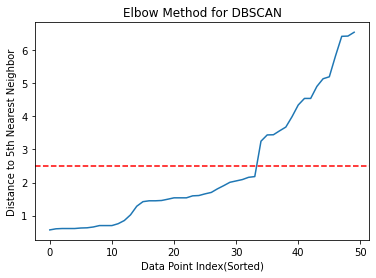

In [10]:
eps = 1
min_samples = 5
n = min_samples

neigh = NearestNeighbors(n_neighbors=n)
neigh.fit(embedding_matrix)
distances, indices = neigh.kneighbors(embedding_matrix)
pri

sorted_distances = np.sort(distances[:, n-1])
# plt.yticks(np.arange(1, 6, 2))
plt.plot(np.arange(len(embedding_matrix)), sorted_distances)
plt.axhline(y=2.5, color='r', linestyle='--')
plt.xlabel('Data Point Index(Sorted)')
plt.ylabel(f'Distance to {n}th Nearest Neighbor')
plt.title('Elbow Method for DBSCAN')
plt.show()

In [11]:
# visualize_embeddings(embedding_matrix, color=torch.zeros(embedding_matrix.shape[0]))
clustering = DBSCAN(eps = 1.5, min_samples=5).fit(embedding_matrix)

In [12]:
print(len(clustering.core_sample_indices_))

20


In [13]:
print(clustering.labels_)

[ 0 -1  1 -1 -1 -1  0 -1  3  2 -1 -1 -1  2 -1 -1 -1  1 -1 -1 -1  1 -1  3
  0  2 -1  1 -1  3  0 -1 -1 -1  0  3  2  2  0  0  2 -1  1 -1  0 -1  3  0
 -1  1]


In [14]:
label_to_node = {}
for index, label in enumerate(clustering.labels_):
    if label not in label_to_node:
        label_to_node[label] = [index + 1]
    else:
        label_to_node[label].append(index + 1)

for key in label_to_node.keys():
    if key == -1:
        continue
    print(key, sorted(label_to_node[key]))

0 [1, 7, 25, 31, 35, 39, 40, 45, 48]
1 [3, 18, 22, 28, 43, 50]
3 [9, 24, 30, 36, 47]
2 [10, 14, 26, 37, 38, 41]


No handles with labels found to put in legend.


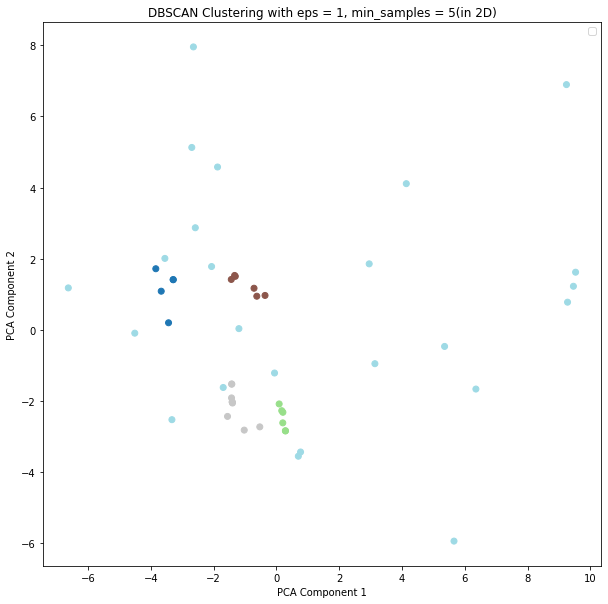

In [15]:
pca = PCA(n_components=2).fit(embedding_matrix)
input_red = pca.transform(embedding_matrix)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(input_red[:, 0], input_red[:, 1], c=[-10 - _ - 1 for _ in clustering.labels_], cmap='tab20')
plt.title(f'DBSCAN Clustering with eps = {eps}, min_samples = {min_samples}(in 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [37]:
brc = Birch(n_clusters=None)
brc.fit(embedding_matrix)

Birch(n_clusters=None)

In [38]:
birch_labels = brc.predict(embedding_matrix)
print(len(birch_labels))

50


In [39]:
birch_label_to_node = {}
for index, label in enumerate(birch_labels):
    if label not in birch_label_to_node:
        birch_label_to_node[label] = [index + 1]
    else:
        birch_label_to_node[label].append(index + 1)

for key in birch_label_to_node.keys():
    if key == -1:
        continue
    print(key, sorted(birch_label_to_node[key]))

0 [1, 7, 31, 35, 39, 40]
1 [2]
2 [3, 18, 28]
3 [4, 15]
4 [5]
5 [6, 11]
6 [8]
7 [9, 30]
8 [10, 14, 26, 37, 38, 41]
9 [12]
10 [13]
11 [16]
12 [17]
13 [19]
14 [20]
15 [21]
16 [22, 43, 50]
17 [23]
18 [24]
19 [25, 45]
20 [27, 36, 47]
21 [29]
22 [32]
23 [33]
24 [34]
25 [42]
26 [44]
27 [46]
28 [48]
29 [49]


No handles with labels found to put in legend.


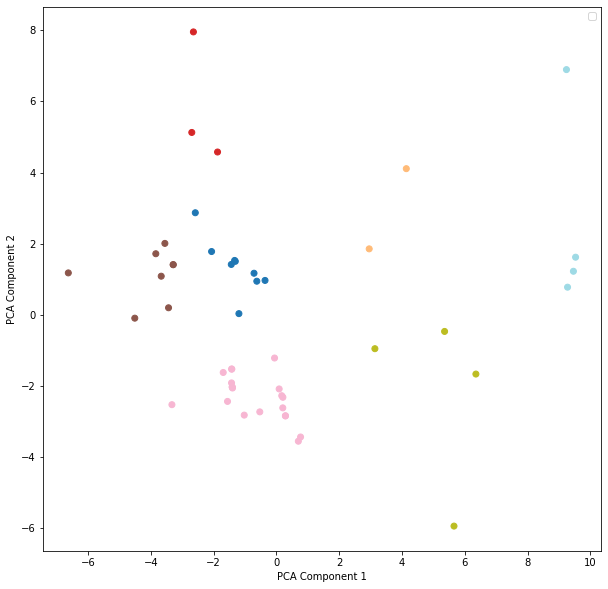

In [36]:
pca = PCA(n_components=2).fit(embedding_matrix)
input_red = pca.transform(embedding_matrix)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(input_red[:, 0], input_red[:, 1], c=[-10 - _ - 1 for _ in birch_labels], cmap='tab20')
# plt.title(f'DBSCAN Clustering with eps = {eps}, min_samples = {min_samples}(in 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()